# Keurig Machine Adoption Using IJC Algorithm

### Settings

##### Set Local Directory

In [1]:
addprocs(32)
@everywhere cd("$(homedir())/Keurig");

##### Load Packages

In [2]:
@everywhere using Distributions;
@everywhere using Optim;
@everywhere using FastGaussQuadrature;
@everywhere using DataFrames;
@everywhere using Gadfly;

Any}) in module DataFrames at /home/xlin0/.julia/v0.4/DataFrames/src/abstractdataframe/abstractdataframe.jl:408 overwritten in module DataFrames at /home/xlin0/.julia/v0.4/DataFrames/src/abstractdataframe/abstractdataframe.jl:408.
    chain(Gadfly.Data...) at /home/xlin0/.julia/v0.4/Gadfly/src/data.jl:57
is ambiguous with: 
    chain(Gadfly.Data...) at /home/xlin0/.julia/v0.4/Gadfly/src/data.jl:57.
To fix, define 
    chain()
before the new definition.
    chain(Gadfly.Data...) at /home/xlin0/.julia/v0.4/Gadfly/src/data.jl:57
is ambiguous with: 
    chain(Gadfly.Data...) at /home/xlin0/.julia/v0.4/Gadfly/src/data.jl:57.
To fix, define 
    chain()
before the new definition.
    chain(Gadfly.Data...) at /home/xlin0/.julia/v0.4/Gadfly/src/data.jl:57
is ambiguous with: 
    chain(Gadfly.Data...) at /home/xlin0/.julia/v0.4/Gadfly/src/data.jl:57.
To fix, define 
    chain()
before the new definition.
    chain(Gadfly.Data...) at /home/xlin0/.julia/v0.4/Gadfly/src/data.jl:57
is ambiguous wit

In [3]:
nprocs()

7

### Solve the Dynamic Programming Problem Once

##### Solve for the Value of holding a Keurig Machine versus not holding

As I assume the consumer would have the machine forever after purchase, I then first need to solve the Bellman equation for holding the machine. $W(1,\nu )=\nu + \int W(1,\nu') dF(\nu')$, where $\nu' \sim N(\mu(\nu), \sigma^2(\nu))$.

Here we assume $\nu'= \alpha_0 + \alpha_1 \nu + \epsilon$ where $\epsilon \sim N(0, 1)$

Set $\gamma$

In [4]:
@everywhere β  = 0.995
@everywhere α0 = 0.0958842;
@everywhere α1 = 0.9501078;
@everywhere σ0 = 0.7828;

Grid of $\nu$

In [5]:
@everywhere nodes = 20; # Degree of Chebyshev Zeros (nodes)
@everywhere order = 5; # Degree of Chebyshev Polynomials
@everywhere (a, b) = (0., 60.); # a need to be greater/equal to 1 for the function to be well behaved.
@everywhere (cnode, cweight)=gausschebyshev(nodes); # Interpolation Nodes
@everywhere tcnode = (cnode+1) * (b-a)/2 + a; # Transformed nodes

Initialize $W(\nu)$

In [6]:
@everywhere W1 = SharedArray(Float64, nodes);

Approximate the Value Function using Chebyshev Interpolation (Regression) based on Judd (1998, P223)

Step 1 Compute the $m \ge n+1$ Chebyshev interpolation nodes on [-1, 1] (Chebyshev Zeros): 
$z_k = -\cos(\frac{2k-1}{2m}\pi)$, $k=1,\dots, m$.

Step 2. Adjust the nodes to the [a,b] interval (desired interval of interpolation).
$x_k = (z_k+1)(\frac{b-a}{2})+a$, $k=1,\dots, m$.

Step 3 Evaluate $f$ at the approximation nodes:
$y_k = f(x_k)$, $k=1,\dots, m$. 

Step 4 Compute Chebyshev coefficients, a_i, i = 0, n:
$a_i = \frac{\sum_{k=1}^m y_k T_i(z_k)}{\sum_{k=1}^m T_i(z_k)^2}$, where $T_i(x)=\cos (i \cos ^{-1} x)$ is the Chebyshev base function. This yield approximation of function $f(x)$, $x \in [a, b]$:
$\hat{f}(x)=\sum_{i=0}^{n} a_i T_i(2\frac{x-a}{b-a} - 1)$. 

Define the Chebyshev Approximation Function

In [7]:
@everywhere T(i, x) = cos((i-1) .* acos(x));
@everywhere Tmat = Float64[T(i,j) for i = 1:(order+1), j in cnode]; # Chebyshev Polynomial Matrix 

In [8]:
# Version 1
@everywhere function capprox(w, nodes::Int64, order::Int64, a::Real, b::Real, x::Real)
    length(w) == nodes ? length(w) : error("function values not the same length as interpolation nodes")
    (cnode, cweight)=gausschebyshev(nodes) # Step 1 - Chebyshev zeros
    tcnode = (cnode+1) * (b-a)/2 + a; # Step 2 - adjust nodes
    Wmat = repmat(w, 1, (order+1)); # Step 3 - function value at transformed node
    T(i, x) = cos((i-1) .* acos(x)) 
    Tmat = Float64[T(i,j) for i = 1:(order+1), j in cnode];# Chebyshev Polynomial Matrix 
    ccoef = diag(Tmat * Wmat) ./ sum(Tmat.^2,2)[:,1]; #Step 4 Compute coefficients
    if (a<=x<=b)
        return sum(Float64[T(i, 2 * (x-a)/(b-a) - 1) * ccoef[i] for i = 1:(order+1)]);
    elseif (x<a)
        abase = capprox(w, nodes, order, a, b, a)
        aslope = (capprox(w, nodes, order, a, b, a+0.0001) - abase)/0.0001
        return abase + aslope * (x-a) # Linear Extrapolation
    else
        bbase = capprox(w, nodes, order, a, b, b)
        bslope = (bbase - capprox(w, nodes, order, a, b, b - 0.0001))/0.0001
        return bbase + bslope * (x-b) # Linear Extrapolation
    end
end

# Version 2
@everywhere function capprox(w, x::Real)
    length(w) == nodes ? length(w) : error("function values not the same length as interpolation nodes")
    Wmat = repmat(w, 1, (order+1)); # Step 3 - function value at transformed node
    ccoef = diag(Tmat * Wmat) ./ sum(Tmat.^2,2)[:,1]; #Step 4 Compute coefficients
    if (a<=x<=b)
        return sum(Float64[T(i, 2 * (x-a)/(b-a) - 1) * ccoef[i] for i = 1:(order+1)]);
    elseif (x<a)
        abase = capprox(w, a)
        aslope = (capprox(w, a+0.0001) - abase)/0.0001
        return abase + aslope * (x-a) # Linear Extrapolation
    else
        bbase = capprox(w, b)
        bslope = (bbase - capprox(w, b - 0.0001))/0.0001
        return bbase + bslope * (x-b) # Linear Extrapolation
    end
end

# Version 3
@everywhere function coefun(ccoef, x::Real)
    if (a<=x<=b)
        return sum(Float64[T(i, 2 * (x-a)/(b-a) - 1) * ccoef[i] for i = 1:(order+1)]);
    elseif (x<a)
        abase = coefun(ccoef, a)
        aslope = (coefun(ccoef, a+0.0001) - abase)/0.0001
        return abase + aslope * (x-a) # Linear Extrapolation
    else
        bbase = ccoef(ccoef, b)
        bslope = (bbase - coefun(ccoef, b - 0.0001))/0.0001
        return bbase + bslope * (x-b) # Linear Extrapolation
    end
end

# Get Coefficient function
@everywhere function getcoef(w)
    Wmat = repmat(w, 1, (order+1)); # Step 3 - function value at transformed node
    ccoef = diag(Tmat * Wmat) ./ sum(Tmat.^2,2)[:,1]; #Step 4 Compute coefficients
    return ccoef
end

Gauss Hermite works well with gaussian density integration (Expected Value)

$\mathbb{E}[f(Y)]=(2\pi\sigma^2)^{-1/2}\int _{-\infty} ^{\infty} f(y) e^{-(y-\mu)^2/(2\sigma^2)}dy = \pi^{-1/2}\sum _{i=1} ^n \omega_i f(\sqrt{2}\sigma x_i +\mu)$

n=15;
(x, wx)=gausshermite(n);
f(x) = (x.^2);
sqrt(1/pi) * sum(f(sqrt(2) * 2 *x) .* wx)

In [9]:
#Gauss Hermite Integration Function
# Version 1
@everywhere function hermiteint(f::Function, nodes::Int64, μ::Real, σ::Real)
    (x, wx)=gausshermite(nodes);
    return sqrt(1/pi) * sum(map(f, sqrt(2)*σ*x + μ) .* wx);
end

# Version 2
@everywhere (hermitenodes, hermitewts)=gausshermite(25);
@everywhere function hermiteint(f::Function, μ::Real, σ::Real)
    return sqrt(1/pi) * sum(map(f, sqrt(2)*σ*hermitenodes + μ) .* hermitewts);
end

Bellman - Value Function Iteration

In [10]:
@everywhere function W1V(W)
    wappx(x::Real) = capprox(W, x);
    function wfun(ν::Real)
        return ν + β * hermiteint(wappx, α0+α1*ν, σ0)
    end
    return map(wfun, tcnode)
end

In [11]:
# function W1V(W::Array{Float64, 1})
@everywhere tol = 1e-8
@everywhere err = 1; 
@everywhere nx = 0;
@everywhere while (err > tol)
    nx = nx+1;
    W1n = W1V(W1)
    err = sum(abs(W1n-W1))
    # println("Error is $(err), and interation is $(nx)")
    W1 = W1n
end

In [12]:
@everywhere w1appx(x) = capprox(W1, nodes, order, a, b, x)

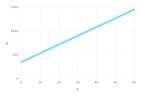

In [13]:
plot(x = collect(0:0.25:60), y = map(w1appx, collect(0:0.25:60)), Geom.point, Geom.line)

### Estimate the Dynamic Program using IJC Algorithm

### Load Relevant Data

Household Machine Adoption Panel

In [49]:
@everywhere hh_adoption = readtable("Data/Machine-Adoption/HH-HW-NewYork-Trips.csv");
@everywhere purch_vec = Array(hh_adoption[:purchased])
@everywhere XMat = Array(hh_adoption[[:series, :price, :t, :mu_val, :warehouse]])

Household Trip Positions

In [50]:
@everywhere hh_pos = map(Int64, readdlm("Data/Machine-Adoption/HH-HW-NewYork-Pos.csv", ','));
@everywhere (ntrips,)= size(hh_pos);

Price State Panel

In [51]:
@everywhere price_states = readtable("Data/Machine-Adoption/HW-Prices-State.csv");
@everywhere price_states_wh = price_states[price_states[:warehouse].==1, :];
@everywhere price_states_rg = price_states[price_states[:warehouse].==0, :];

Transform Price States to the Format that can be used

In [65]:
@everywhere price_wh = Dict{Int64, Any}()
@everywhere for i in unique(price_states_wh[:tstate])
    p_temp = price_states_wh[price_states_wh[:tstate].==i,:]
    s_list = unique(p_temp[:series])
    if in(1, s_list)
        p1_list = Array(p_temp[p_temp[:series].==1, :price_int])
        p1_prob = Array(p_temp[p_temp[:series].==1, :prob])
    else 
        p1_list = [9999.]
        p1_prob = [1.]
    end
    if in(2, s_list)
        p2_list = Array(p_temp[p_temp[:series].==2, :price_int])
        p2_prob = Array(p_temp[p_temp[:series].==2, :prob])
    else 
        p2_list = [9999.]
        p2_prob = [1.]
    end
    if in(3, s_list)
        p3_list = Array(p_temp[p_temp[:series].==3, :price_int])
        p3_prob = Array(p_temp[p_temp[:series].==3, :prob])
    else 
        p3_list = [9999.]
        p3_prob = [1.]
    end
    if in(4, s_list)
        p4_list = Array(p_temp[p_temp[:series].==4, :price_int])
        p4_prob = Array(p_temp[p_temp[:series].==4, :prob])
    else 
        p4_list = [9999.]
        p4_prob = [1.]
    end
    if in(5, s_list)
        p5_list = Array(p_temp[p_temp[:series].==5, :price_int])
        p5_prob = Array(p_temp[p_temp[:series].==5, :prob])
    else 
        p5_list = [9999.]
        p5_prob = [1.]
    end
    nprice = length(p1_list) * length(p2_list) * length(p3_list) * length(p4_list) * length(p5_list)
    availvec = zeros(Float64, nprice, 5);
    for s in 1:5
        if in(s, s_list)
            availvec[:,s] = 1.
        end
    end
    pricevec = zeros(Float64, nprice, 5);
    pricep  = zeros(Float64, nprice);
    j = 0
    for (i1, p1) in enumerate(p1_list), (i2, p2) in enumerate(p2_list), (i3, p3) in enumerate(p3_list), (i4, p4) in enumerate(p4_list), (i5, p5) in enumerate(p5_list)
        j += 1;
        pricevec[j,:] = [p1, p2, p3, p4, p5]
        pricep[j] = p1_prob[i1] * p2_prob[i2] * p3_prob[i3] * p4_prob[i4] * p5_prob[i5]
    end    
    pricevec = pricevec[pricep.>=1e-04, :]
    availvec = availvec[pricep.>=1e-04, :]
    pricep = pricep[pricep.>=1e-04]
    pricep = pricep./sum(pricep)
    price_wh[i] = Dict(:price => pricevec, :avail => availvec, :prob => pricep)
end

In [66]:
@everywhere price_rg = Dict{Int64, Any}()
@everywhere for i in unique(price_states_rg[:tstate])
    p_temp = price_states_rg[price_states_rg[:tstate].==i,:]
    s_list = unique(p_temp[:series])
    if in(1, s_list)
        p1_list = Array(p_temp[p_temp[:series].==1, :price_int])
        p1_prob = Array(p_temp[p_temp[:series].==1, :prob])
    else 
        p1_list = [9999.]
        p1_prob = [1.]
    end
    if in(2, s_list)
        p2_list = Array(p_temp[p_temp[:series].==2, :price_int])
        p2_prob = Array(p_temp[p_temp[:series].==2, :prob])
    else 
        p2_list = [9999.]
        p2_prob = [1.]
    end
    if in(3, s_list)
        p3_list = Array(p_temp[p_temp[:series].==3, :price_int])
        p3_prob = Array(p_temp[p_temp[:series].==3, :prob])
    else 
        p3_list = [9999.]
        p3_prob = [1.]
    end
    if in(4, s_list)
        p4_list = Array(p_temp[p_temp[:series].==4, :price_int])
        p4_prob = Array(p_temp[p_temp[:series].==4, :prob])
    else 
        p4_list = [9999.]
        p4_prob = [1.]
    end
    if in(5, s_list)
        p5_list = Array(p_temp[p_temp[:series].==5, :price_int])
        p5_prob = Array(p_temp[p_temp[:series].==5, :prob])
    else 
        p5_list = [9999.]
        p5_prob = [1.]
    end
    nprice = length(p1_list) * length(p2_list) * length(p3_list) * length(p4_list) * length(p5_list)
    availvec = zeros(Float64, nprice, 5);
    for s in 1:5
        if in(s, s_list)
            availvec[:,s] = 1.
        end
    end
    pricevec = zeros(Float64, nprice, 5);
    pricep  = zeros(Float64, nprice);
    j = 0
    for (i1, p1) in enumerate(p1_list), (i2, p2) in enumerate(p2_list), (i3, p3) in enumerate(p3_list), (i4, p4) in enumerate(p4_list), (i5, p5) in enumerate(p5_list)
        j += 1;
        pricevec[j,:] = [p1, p2, p3, p4, p5]
        pricep[j] = p1_prob[i1] * p2_prob[i2] * p3_prob[i3] * p4_prob[i4] * p5_prob[i5]
    end
    pricevec = pricevec[pricep.>=1e-04, :]
    availvec = availvec[pricep.>=1e-04, :]
    pricep = pricep[pricep.>=1e-04]
    price_rg[i] = Dict(:price => pricevec, :avail => availvec, :prob => pricep)
end

In [69]:
@everywhere nt = length(unique(price_states[:tstate]))
@everywhere W0_wh = SharedArray(Float64, nt, nodes);
@everywhere W0_rg = SharedArray(Float64, nt, nodes);

##### Functions for Approximating the W Function

In [98]:
# Kernal Density Function
@everywhere function kden(θ1::Vector, θ0::Matrix, h::Real)
    cdist = MvNormal(θ1, eye(length(θ1)))
    denv = pdf(cdist, broadcast(-, θ0, θ1)/h)
    return denv ./ sum(denv)
end

# W0 approximation
@everywhere (nr, nc) = (nt, nodes)
@everywhere N = 100 # Number of lags to store and use for value function approximation.
@everywhere function WApprox(theta::Vector, thetav::Matrix, wmat::Array{Float64,3})
    wts = kden(theta, thetav, 0.01)'
    wt = reshape(repmat(wts, nt*nodes), nodes, nt, N)
    return (sum(wt .* wmat, 3)[:,:,1])'
end

# Bellman Operation on the Value Function once
function W0V!(W0::SharedArray{Float64, 2}, wh::Int64)
    @sync @parallel for i in 1:(nr-1)
        Wn = W0[(i+1),:]
        EW0Fun(x::Real) = capprox(vec(Wn), x::Real)
        EW0 = exp(β * Float64[hermiteint(EW0Fun, α0+α1*ν, σ0) for ν in tcnode])
        if wh == 1
            nprice = length(price_wh[i][:prob])
            util_mat = sum(exp(broadcast(+, ϑ', βp * price_wh[i][:price])/100) .* price_wh[i][:avail], 2)
            util_mat = broadcast(*, util_mat, repmat(W1', nprice))
            Wnew = sum(broadcast(*, log(broadcast(+, EW0', util_mat)), price_wh[i][:prob]), 1)
        else
            nprice = length(price_rg[i][:prob])
            util_mat = sum(exp(broadcast(+, ϑ', βp * price_rg[i][:price])/100) .* price_rg[i][:avail], 2)
            util_mat = broadcast(*, util_mat, repmat(W1', nprice))
            Wnew = sum(broadcast(*, log(broadcast(+, EW0', util_mat)), price_rg[i][:prob]), 1)
        end
        W0[i,:] = Wnew
    end
    W0[nr,:] = W0[(nr-1),:]
    return W0;
end

# For values of tstate and purchased - function of delta
function vfun(series::Int64, price::Real, ts::Int64, mu::Real, wh::Int64)
    if wh==1
        Wn = vec(W0_wh[ts,:])
    else
        Wn = vec(W0_rg[ts,:])
    end
    coef = getcoef(vec(Wn))
    if series==0
        EW0F(x::Real) = coefun(coef, x::Real)
        val = exp(β*hermiteint(EW0F, α0+α1*mu, σ0))
    else
        val = exp((ϑ[series] + βp*price + w1appx(mu))/100)
    end
    return(val)
end

# Create a New column which stores the choice specific values
(nobs, nvars) = size(hh_adoption)
val = SharedArray(Float64, nobs);
function vfun!()
    for i in 1:nobs
        val[i]= vfun(XMat[i, 1], XMat[i, 2], XMat[i, 3], XMat[i, 4], XMat[i, 5])
    end
end

vfun! (generic function with 1 method)

In [99]:
# Likelihood Function
cp = SharedArray(Float64, ntrips)
function llfun!()
    @sync @parallel for trip in 1:ntrips
        s_i = hh_pos[trip,2]
        e_i = hh_pos[trip,3]
        cp[trip] = sum(log(val[s_i:e_i]/sum(val[s_i:e_i])) .* purch_vec[s_i:e_i])
    end
    return sum(cp)
end

llfun! (generic function with 1 method)

##### Settings for Estimation

In [109]:
N = 100 # Number of lags to store and use for value function approximation.

100

##### Function for Posterior Proportions

In [101]:
function postd(l1::Real, l0::Real, theta1::Vector, theta0::Vector, bhat::Vector, sigb::Matrix)
    return exp(l1 + log(pdf(MvNormal(bhat, sigb), theta1)) - l0 - log(pdf(MvNormal(bhat, sigb), theta0)))
end

postd (generic function with 1 method)

##### MCMC Settings

In [102]:
burnin = 0;
thin   = 10;
draws  = 1000;
totdraws = draws*thin + burnin;

##### Priors

In [103]:
bhat = zeros(Float64, 6)
sigb = eye(6)*100

6x6 Array{Float64,2}:
 100.0    0.0    0.0    0.0    0.0    0.0
   0.0  100.0    0.0    0.0    0.0    0.0
   0.0    0.0  100.0    0.0    0.0    0.0
   0.0    0.0    0.0  100.0    0.0    0.0
   0.0    0.0    0.0    0.0  100.0    0.0
   0.0    0.0    0.0    0.0    0.0  100.0

Random Walk MH outer loop

In [104]:
@everywhere theta0 = zeros(6)
#theta0[2] = 0.05
# Let the proposal variance to be small
@everywhere sigs = eye(6)/1000
@everywhere walkdistr = MvNormal(zeros(6), sigs);

Initialize storage for proposal parameters and corresponding w

In [105]:
thtild = zeros(Float64, 6, N);
wtild_wh = zeros(Float64, nodes, nt, N);
wtild_rg = zeros(Float64, nodes, nt, N);

In [106]:
@everywhere ϑ = theta0[1:5];
@everywhere βp = theta0[6];
W0_wh[:] =  WApprox(theta0, thtild, wtild_wh) # Approximate the new W0_wh
W0_rg[:] =  WApprox(theta0, thtild, wtild_rg) # Approximate the new W0_rg
W0V!(W0_wh, 1)
W0V!(W0_rg, 0)
vfun!() # Compute the choice specific value for each observation
l0 = llfun!();

Initialize storage of MCMC draws

In [107]:
thatd = zeros(Float64, draws, 6);

Let the bandwidth to be very small

In [108]:
## MCMC Draws
for d=1:totdraws
    # Proposed theta
    @everywhere theta1 = theta0 + vec(rand(walkdistr, 1))
        
    # Define the relevant parameters
    @everywhere ϑ = theta1[1:5];
    @everywhere βp = theta1[6];
    
    # Approximate W function
    W0_wh[:] =  WApprox(theta0, thtild, wtild_wh) # Approximate the new W0_wh
    W0_rg[:] =  WApprox(theta0, thtild, wtild_rg) # Approximate the new W0_rg
    
    # Bellman Iteration
    W0V!(W0_wh, 1)
    W0V!(W0_rg, 0)

    # Compute choice specific value
    vfun!() # Compute the choice specific value for each observation
    l1 = llfun!();
    
    # Update the draws storage
    wtild_wh[:, :, 2:end] = wtild_wh[:, :, 1:(end-1)]
    wtild_wh[:, :, 1] = Array(W0_wh')
    wtild_rg[:, :, 2:end] = wtild_rg[:, :, 1:(end-1)]
    wtild_rg[:, :, 1] = Array(W0_rg')
    thtild[:, 2:end] = thtild[:, 1:(end-1)]
    thtild[:, 1] = theta1
    
    alpha = min(1, postd(l1, l0, theta1, theta0, bhat, sigb))
    if rand() <= alpha
        theta0 = theta1
        l0 = l1
    end

    # Store the posterior draws of mean betas and sigmas
    if ((d > burnin) && (d % thin == 0))
        indx = ceil(Int64, (d - burnin)/thin) 
        thatd[indx, :] = theta0;
    end

    # Indicate the progress
    println(theta0)
    println("Finished drawing $(d) out of $(totdraws)")
end

[0.0,0.0,0.0,0.0,0.0,0.0]
Finished drawing 1 out of 10000
[0.0,0.0,0.0,0.0,0.0,0.0]
Finished drawing 2 out of 10000
[0.0012896362001056226,-0.02430230339588597,-0.002071755562173086,-0.06056839250556477,-0.031461840781895116,-0.02569499206177788]
Finished drawing 3 out of 10000
[0.01754557222369143,-0.04824345938849725,-0.0025274621782386177,-0.07340740477281973,-0.048705523658950284,-0.005832826720002099]
Finished drawing 4 out of 10000
[0.0646170351013736,-0.08669782037149312,0.050740101262545384,-0.10766592231684931,-0.01221417196847746,0.041682921588304514]
Finished drawing 5 out of 10000
[0.033949842239040996,-0.053484869945593184,0.08914454348509358,-0.13428330968563265,0.014032190772857195,0.01395615355417024]
Finished drawing 6 out of 10000
[0.020003970593312694,-0.08162201546440812,0.06965407041335721,-0.07557322192661026,0.019142125304505243,-0.0022174573767473824]
Finished drawing 7 out of 10000
[0.014409497877027335,-0.10703075856713706,0.08762454556737954,-0.06189575655860

Socket from unknown remote worker in worker 2

[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 768 out of 10000
[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 769 out of 10000
[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 770 out of 10000
[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 771 out of 10000
[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 772 out of 10000
[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 773 out of 10000
[-0.043154570048029854,0.074780325753753

Socket from unknown remote worker in worker 2

[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 967 out of 10000
[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 968 out of 10000
[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 969 out of 10000
[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 970 out of 10000
[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 971 out of 10000
[-0.043154570048029854,0.07478032575375354,0.006708753146914188,0.030975196893547503,0.23351910159058614,-3.4307142951054774]
Finished drawing 972 out of 10000
[-0.043154570048029854,0.074780325753753

LoadError: LoadError: InterruptException:
while loading In[108], in expression starting on line 2